# Deep Learning with ehrdata: The physionet2012 challenge

This notebook shows how ehrdata integrates with deep learning methods.

We are interested to show and explore patient representations at different times of their Intensive Care Unit (ICU) stay.

For this, we will use the public [physionet2012 challenge](https://physionet.org/content/challenge-2012/1.0.0/) dataset of ICU stays. See the link for more information.

We train a sequence model, check its classification performance on in-hospital mortality, and show patient representations at different times.

Finally, the patient representations can be interactively explored in this notebook using Vitessce.

<span style="color:blue">Warning: This notebook requires features introduced currently in the [time-series branch of ehrapy](https://github.com/theislab/ehrapy/tree/feature/time-series). To run this notebook, you need to set up your environment with this branch of ehrapy. </span>.

Resources

- Physionet2012 Challenge Paper: https://ieeexplore.ieee.org/abstract/document/6420376
- Data Link: https://physionet.org/content/challenge-2012/1.0.0/

## Imports

In [ ]:
!pip install bottleneck ehrapy

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn.functional as F
from pathlib import Path
import ehrdata as ed
import vitessce as vit
import ehrapy as ep
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, f1_score, auc, confusion_matrix

import anndata as ad

from vitessce.data_utils import optimize_adata, VAR_CHUNK_SIZE

In [ ]:
torch.manual_seed(42)

## Data preparation
The physionet2012 challenge dataset is one of the ready-to-use datasets of `ehrdata`. See the documentation for further information.

In [ ]:
edata = ed.dt.physionet2012()

In [4]:
edata

View of EHRData object with n_obs × n_vars × n_t = 11988 × 37 × 48
    obs: 'set', 'Age', 'Gender', 'Height', 'ICUType', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'
    var: 'Parameter'
    tem: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47'
    layers: 'tem_layer'
    shape of .tem_layer: (11988, 37, 48)

We split the data into train, validation, and test splits.

In [5]:
edata_train = edata[edata.obs["set"] == "set-a"]
edata_val = edata[edata.obs["set"] == "set-b"]
edata_test = edata[edata.obs["set"] == "set-c"]


We perform a zero-mean and unit-variance normalization. For this, we first prepare two useful functions for scaling and imputing longitudinal data.

In [ ]:
class StandardScaler3D:
    """Standardize features by removing the mean and scaling to unit variance, across all samples and timesteps."""

    def __init__(self):
        """Standardize features by removing the mean and scaling to unit variance, across all samples and timesteps.

        This class is in concept similar to :class:`sklearn.preprocessing.StandardScaler`, but for a 3D array of shape (n_samples, n_features, n_timesteps).
        """
        self.mean_ = None
        self.std_ = None

    def _fit(self, data: np.ndarray) -> None:
        # Compute mean and std along the (0, 2) axes (samples and timesteps)
        self.mean_ = np.nanmean(data, axis=(0, 2), keepdims=True)
        self.scale_ = np.nanstd(data, axis=(0, 2), keepdims=True)

        self.scale_[self.scale_ == 0] = 1.0

    def fit(self, edata: ed.EHRData, layer: str = "tem_layer") -> None:
        """Fit the StandardScaler3D object to the input data.

        Computes the mean and standard deviation for each feature across all samples and timesteps from the input EHRData's `.r` field.
        If missing values are present, they are ignored during this computation.

        Args:
            edata: Central data object.
            layer: The layer of the EHRData object to use for the normalization.
        """
        if not isinstance(edata, ed.EHRData):
            msg = "Input must be an EHRData object."
            raise ValueError(msg)

        self._fit(edata.layers[layer])

    def _transform(self, data: np.ndarray) -> np.ndarray:
        return (data - self.mean_) / self.scale_

    def transform(self, edata: ed.EHRData, *, copy: bool = False) -> ed.EHRData | None:
        """Standardize the input data.

        If missing values are present, they are ignored and remain missing values.

        Args:
            edata: Central data object
            copy: Whether to return a copy of the input data.

        Returns:
            The standardized input data.
        """
        if edata.layers["tem_layer"].ndim != 3:
            msg = "Input EHRData's layers['tem_layer'] field must be a 3D array."
            raise ValueError(msg)

        if copy:
            edata = edata.copy()
            edata.layers["tem_layer"] = self._transform(edata.layers["tem_layer"])
            return edata
        else:
            edata.layers["tem_layer"] = self._transform(edata.layers["tem_layer"])
            return None

    def fit_transform(self, edata: ed.EHRData, *, copy: bool = False) -> ed.EHRData | None:
        """Fit the StandardScaler3D to the input data, and apply the normalization to it.

        Args:
            edata: EHRData, or array of shape (n_samples, n_features, n_timesteps).
            copy: Whether to return a copy of the input data.

        Returns:
            The standardized input data.
        """
        self.fit(edata)
        return self.transform(edata, copy=copy)


class LOCFImputer:
    """Impute missing values by carrying forward the last observed value."""

    def __init__(self, fallback_method: str = "mean"):
        """Impute missing values by carrying forward the last observed value.

        Args:
            fallback_method: The method to use for imputing missing values of timesteps before the first observation for a subject.
            Currently, only 'mean' is supported.
        """
        if fallback_method != "mean":
            msg = "Only 'mean' is supported as a fallback method."
            raise ValueError(msg)

        self.fallback_method = fallback_method
        self.mean_ = None

    def fit(self, edata: ed.EHRData) -> None:
        """Fit the LOCFImputer to the input data."""
        self.feature_means = np.nanmean(np.nanmean(edata.layers["tem_layer"], axis=0), axis=1)

    def transform(self, edata: ed.EHRData, *, copy: bool = False) -> ed.EHRData:
        """Impute missing values by carrying forward the last observed value."""
        X = xr.DataArray(edata.layers["tem_layer"])
        X = X.ffill("dim_2")

        mask = X.isnull().values

        feature_means_broadcasted = np.repeat(
            np.repeat(self.feature_means.reshape(1, -1, 1), X.shape[0], axis=0), X.shape[2], axis=2
        )

        X.values[mask] = feature_means_broadcasted[mask]

        if copy:
            edata = edata.copy()
            edata.layers["tem_layer"] = X.values
            return edata
        else:
            edata.layers["tem_layer"] = X.values

            return None

    def fit_transform(self, edata: ed.EHRData, *, copy: bool = False) -> ed.EHRData | None:
        """Fit the LOCFImputer to the input data, and apply the imputation to it."""
        self.fit(edata)
        return self.transform(edata)

In [7]:
scaler3d = StandardScaler3D()

scaler3d.fit_transform(edata_train)
scaler3d.transform(edata_val)
scaler3d.transform(edata_test)

To impute missing values, we now perform last observation carried forward imputation.
There are also more sophisticated methods for time-series imputation, e.g. [SAITS (Du et al., 2023)](https://doi.org/10.1016/j.eswa.2023.119619).

In [8]:
locf = LOCFImputer()

locf.fit_transform(edata_train)
locf.transform(edata_val)
locf.transform(edata_test)

Finally, let us briefly explore the shape of the data: We have 37 numeric features, measured for 48 hours, and roughly 4'000 patients per split. The dataset is imbalanced, with ca 14% in-hospital death cases per split.

In [9]:
edata_train

EHRData object with n_obs × n_vars × n_t = 3997 × 37 × 48
    obs: 'set', 'Age', 'Gender', 'Height', 'ICUType', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'
    var: 'Parameter'
    tem: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47'
    layers: 'tem_layer'
    shape of .tem_layer: (3997, 37, 48)

In [10]:
edata_val

EHRData object with n_obs × n_vars × n_t = 3993 × 37 × 48
    obs: 'set', 'Age', 'Gender', 'Height', 'ICUType', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'
    var: 'Parameter'
    tem: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47'
    layers: 'tem_layer'
    shape of .tem_layer: (3993, 37, 48)

In [11]:
edata_test

EHRData object with n_obs × n_vars × n_t = 3998 × 37 × 48
    obs: 'set', 'Age', 'Gender', 'Height', 'ICUType', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival', 'In-hospital_death'
    var: 'Parameter'
    tem: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47'
    layers: 'tem_layer'
    shape of .tem_layer: (3998, 37, 48)

In [12]:
print(
    f"positive rate in edata_train: {edata_train.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_train.obs['In-hospital_death'].sum()}"
)

print(
    f"positive rate in edata_val: {edata_val.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_val.obs['In-hospital_death'].sum()}"
)

print(
    f"positive rate in edata_test: {edata_test.obs['In-hospital_death'].mean():.4f}, absolute count: {edata_test.obs['In-hospital_death'].sum()}"
)

positive rate in edata_train: 0.1386, absolute count: 554
positive rate in edata_val: 0.1422, absolute count: 568
positive rate in edata_test: 0.1463, absolute count: 585


## Model preparation
We build a small sequence model in pytorch. More elaborate model architectures have been proposed for this dataset. Here, for demonstration purposes and to avoid complexity, we focus on a simple architecture.

In a nutshell, the model has a GRU block as sequence model, and a classification head.

In [13]:
class MinimalRNN(nn.Module):
    """Minimal RNN model for classification."""

    def __init__(self, input_size, hidden_size, num_classes, dropout=0.0, *, class_weight=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self._rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.class_weight = class_weight
        self.dropout = nn.Dropout(dropout)
        self.best_val_loss = float("inf")

    def rnn(self, x):
        """RNN call, where X is of shape (batch, input_size, seq_len)."""
        return self._rnn(x.transpose(2, 1))

    def forward(self, x):
        """Forward pass."""
        out, _ = self.rnn(x)
        out = self.fc(self.dropout(out[:, -1, :]))
        return out

    def _compute_class_weight(self, labels):
        """Compute inverse label frequency weight."""
        class_counts = torch.bincount(labels.view(-1), minlength=self.num_classes)

        weight = 1.0 / (class_counts.float() + 1e-6)  # Avoid division by zero
        weight /= weight.sum()
        return weight

    def train_step(self, batch):
        """Training step for a single batch."""
        x, y = batch
        y_pred = self(x)
        weight = self._compute_class_weight(y) if self.class_weight else None
        loss = F.cross_entropy(y_pred.view(-1, self.num_classes), y.view(-1), weight=weight)
        return loss

    def fit(self, dataloader, val_loader=None, epochs=10, model_save_path="best_model.pth"):
        """Fit the model on a dataset."""
        for epoch in range(epochs):
            self.train()
            for batch in dataloader:
                loss = self.train_step(batch)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            print(f"epoch {epoch}, train_loss: {loss.item()}")

            if val_loader:
                with torch.no_grad():
                    self.eval()
                    val_loss = 0
                    for i, batch in enumerate(val_loader):
                        if i < len(val_loader):
                            val_loss += self.train_step(batch).item()

                    val_loss /= len(val_loader)

                    if val_loss < self.best_val_loss:
                        self.best_val_loss = val_loss
                        self.best_model_epoch = epoch
                        torch.save(self.state_dict(), model_save_path)

                        print(f"Best model saved with val_loss: {val_loss}")

                    print(f"epoch {epoch}, val_loss: {val_loss}")

        print(
            f"Loading best model from {model_save_path} with val_loss: {self.best_val_loss} (epoch {self.best_model_epoch})"
        )
        self.load_state_dict(torch.load(model_save_path))
        self.eval()

    def predict_proba(self, x):
        """Predict probabilities for a batch of inputs."""
        self.eval()
        with torch.no_grad():
            return F.softmax(self(x), dim=1)

    def predict_label(self, x):
        """Predict labels for a batch of inputs."""
        self.eval()
        with torch.no_grad():
            return torch.argmax(self(x), dim=1)

We prepare the data into pytorch DataLoaders

In [14]:
train_tensor_dataset = TensorDataset(
    torch.tensor(edata_train.layers["tem_layer"]).to(torch.float32),
    torch.tensor(edata_train.obs["In-hospital_death"]).to(torch.long),
)
train_dataloader = DataLoader(train_tensor_dataset, batch_size=128)

val_tensor_dataset = TensorDataset(
    torch.tensor(edata_train.layers["tem_layer"]).to(torch.float32),
    torch.tensor(edata_train.obs["In-hospital_death"]).to(torch.long),
)
val_dataloader = DataLoader(val_tensor_dataset, batch_size=128)

Now, lets fit the model. On a modern laptop, this takes less than 30 seconds.

In [ ]:
model = MinimalRNN(37, 8, 2, class_weight=True)

model.fit(train_dataloader, val_dataloader, epochs=25)

### Optional: load best model from before

In [16]:
# model = MinimalRNN(37, 8, 2, class_weight = True)
# model.load_state_dict(torch.load("best_model.pth"))

## Model Evaluation

We evaluate the classification metrics on the binary classification task of in-hospital mortality. The simple setup is not aimed at competing with SOTA classification performance (see e.g. [Zhang et al. 2021](https://doi.org/10.48550/arXiv.2110.05357)) and omits tricks such as batch oversampling.

The model evaluation shows a superior F1 score compared to a constant 0, 1, and random baseline.


In [17]:
model.eval()

MinimalRNN(
  (_rnn): GRU(37, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=2, bias=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [18]:
def evaluate_binary_classification(model, X, y_true_long):
    """Evaluation metrics for binary classification."""
    predicted_proba_long = np.array(model.predict_proba(torch.tensor(X).to(torch.float32)))
    predicted_label_long = predicted_proba_long.argmax(axis=1)

    roc_auc_result = roc_auc_score(y_true_long, predicted_proba_long[:, 1])
    precision, recall, _thresholds = precision_recall_curve(y_true_long, predicted_proba_long[:, 1])
    pr_auc_result = auc(recall, precision)
    f1_result = f1_score(y_true_long, predicted_label_long)
    accuracy_result = accuracy_score(y_true_long, predicted_label_long)
    print(
        f"roc_auc_result: {roc_auc_result:.5f}\npr_auc_result: {pr_auc_result:.5f}\nf1_result: {f1_result:.5f}\naccuracy_result: {accuracy_result:.5f}"
    )

    print("Confusion matrix:\nTN FP\nFN TP")
    print(confusion_matrix(y_true_long, predicted_label_long))

In [19]:
evaluate_binary_classification(model, edata_test.layers["tem_layer"], edata_test.obs["In-hospital_death"])

roc_auc_result: 0.83910
pr_auc_result: 0.48851
f1_result: 0.48048
accuracy_result: 0.76038
Confusion matrix:
TN FP
FN TP
[[2597  816]
 [ 142  443]]


### Baseline

To put the above results into context, lets briefly check baselines:

1. Predict all zeros
2. Predict all ones
3. Randomly predict ones at the rate of the train set
4. Predict all correct

In [20]:
class ZeroPredictor(nn.Module):
    """Predicts always the negative class."""

    def __init__(self):
        super().__init__()

    def predict_proba(self, x):
        """Predict probabilities as 1 for the negative class."""
        predicted_probabilities = torch.zeros(x.size(0), 2)
        predicted_probabilities[:, 0] = 1
        return predicted_probabilities

    def predict_label(self, x):
        """Predict the negative class label."""
        return torch.zeros(x.size(0), 1)


class OnePredictor(nn.Module):
    """Predicts always the positive class."""

    def __init__(self):
        super().__init__()

    def predict_proba(self, x):
        """Predict probabilities as 1 for the positive class."""
        predicted_probabilities = torch.zeros(x.size(0), 2)
        predicted_probabilities[:, 1] = 1
        return predicted_probabilities

    def predict_label(self, x):
        """Predict the positive class label."""
        return torch.ones(x.size(0), 1)


class RandomPredictor(nn.Module):
    """Predicts the positive class at random with train-set based frequency."""

    def __init__(self):
        super().__init__()
        self.rng = np.random.default_rng(42)

    def predict_proba(self, x):
        """Predict probabilities at random."""
        predicted_labels = np.zeros((x.size(0), 2))
        predicted_labels[:, 0] = self.rng.random(x.size(0)) < 0.1424  # frequency of positive class in training set
        predicted_labels[:, 1] = 1 - predicted_labels[:, 0]

        return predicted_labels

    def predict_label(self, x):
        """Predict labels at random."""
        predicted_labels = self.predict_proba(x)
        return predicted_labels[:, 1]

In [21]:
zero_predictor = ZeroPredictor()
evaluate_binary_classification(zero_predictor, edata_test.layers["tem_layer"], edata_test.obs["In-hospital_death"])

roc_auc_result: 0.50000
pr_auc_result: 0.57316
f1_result: 0.00000
accuracy_result: 0.85368
Confusion matrix:
TN FP
FN TP
[[3413    0]
 [ 585    0]]


In [22]:
one_predictor = OnePredictor()
evaluate_binary_classification(one_predictor, edata_test.layers["tem_layer"], edata_test.obs["In-hospital_death"])

roc_auc_result: 0.50000
pr_auc_result: 0.57316
f1_result: 0.25529
accuracy_result: 0.14632
Confusion matrix:
TN FP
FN TP
[[   0 3413]
 [   0  585]]


In [23]:
random_predictor = RandomPredictor()
evaluate_binary_classification(random_predictor, edata_test.layers["tem_layer"], edata_test.obs["In-hospital_death"])

roc_auc_result: 0.49630
pr_auc_result: 0.50768
f1_result: 0.24800
accuracy_result: 0.24762
Confusion matrix:
TN FP
FN TP
[[ 494 2919]
 [  89  496]]


## Patient Representation

We have seen how the ehrdata format provides convenient input to train a sequence model in pytorch.

Now, we show how the patient representations of such a sequence model can be stored and visualized with `ehrdata` and `ehrapy`. For this, we visualize 2D projections of the patient representations at `hour 4`, `hour 24`, and `hour 48`.

### Patient representation into `edata`
First, we store the patient representations of these timesteps into our `edata` object.

In [24]:
rnn_timestep_4_test = model.rnn(torch.tensor(edata_test.layers["tem_layer"]).to(torch.float32))[0][:, 3, :]
edata_test.obsm["grud timestep 4"] = rnn_timestep_4_test.detach().numpy()

In [25]:
rnn_timestep_24_test = model.rnn(torch.tensor(edata_test.layers["tem_layer"]).to(torch.float32))[0][:, 23, :]
edata_test.obsm["grud timestep 24"] = rnn_timestep_24_test.detach().numpy()

In [26]:
rnn_timestep_48_test = model.rnn(torch.tensor(edata_test.layers["tem_layer"]).to(torch.float32))[0][:, -1, :]
edata_test.obsm["grud timestep 48"] = rnn_timestep_48_test.detach().numpy()

In [27]:
edata_test.obs["In-hospital_death_text"] = edata_test.obs["In-hospital_death"].replace({1: "Yes", 0: "No"})

### Visualization with ehrapy
Now, we use ehrapy's `neighbors` computation to compute a neighborhood graph on this representation; this is then used to compute a 2D UMAP representation. This can be plotted with `ehrapy`.

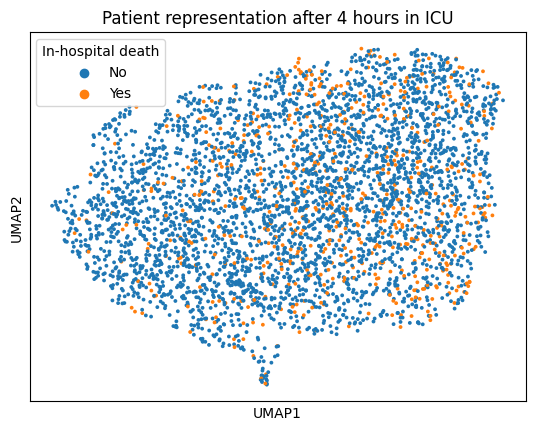

In [28]:
edata_test.X = np.zeros(edata_test.shape[:2])  # workaround until https://github.com/theislab/ehrapy/pull/969 released
ep.pp.neighbors(edata_test, use_rep="grud timestep 4", key_added="grud timestep 4 neighbors")
ep.tl.umap(edata_test, neighbors_key="grud timestep 4 neighbors")
edata_test.obsm["X_umap_grud timestep 4"] = edata_test.obsm["X_umap"].copy()
ep.pl.umap(
    edata_test, title="Patient representation after 4 hours in ICU", color=["In-hospital_death_text"], show=False
)
plt.legend(title="In-hospital death")
plt.show()

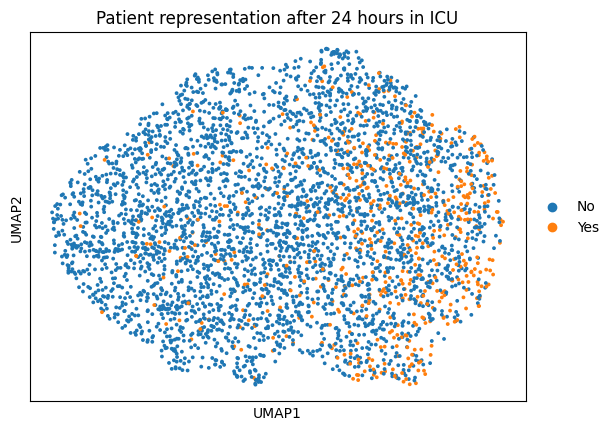

In [29]:
ep.pp.neighbors(edata_test, use_rep="grud timestep 24", key_added="grud timestep 24 neighbors")
ep.tl.umap(edata_test, neighbors_key="grud timestep 24 neighbors")
edata_test.obsm["X_umap_grud timestep 24"] = edata_test.obsm["X_umap"].copy()
ep.pl.umap(
    edata_test, title="Patient representation after 24 hours in ICU", color=["In-hospital_death_text"], show=False
)
plt.show()

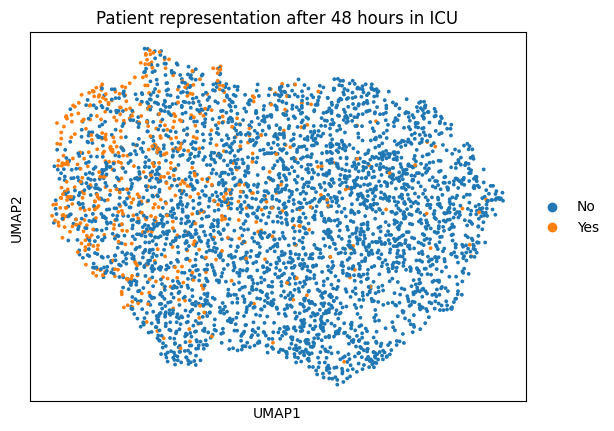

In [30]:
ep.pp.neighbors(edata_test, use_rep="grud timestep 48", key_added="grud timestep 48 neighbors")
ep.tl.umap(edata_test, neighbors_key="grud timestep 48 neighbors")
edata_test.obsm["X_umap_grud timestep 48"] = edata_test.obsm["X_umap"].copy()
ep.pl.umap(
    edata_test, title="Patient representation after 48 hours in ICU", color=["In-hospital_death_text"], show=False
)
plt.show()

As purely exploratory visuals, the representations seem to mix patient representations of the two class labels well at 4h. After 24h and 48h, the patient representations of the two different classes appear to mix less arbitrarily. This could be an indication of patient representations for the two different classes to show class-specific dissimilarities.

Since this is not an in-depth analysis of this dataset, and the cue is purely visual, we do not draw conclusions here. Rather, this outlines how `ehrdata` and `ehrapy` can help explore patient representations in a visual manner. Further methods for e.g. unsupervised clustering, differential testing between groups, and trajectory analyses are integrated in `ehrapy` to perform further exploratory analyses on such representations.


## Interactive Visualization with Vitessce

On top of the static plots above, `ehrdata` integrates with Vitessce ([Keller et al. 2024](https://doi.org/10.1038/s41592-024-02436-x)). Vitessce allows to interactively explore representations, for example in a Jupyter Notebook as Widget.

In [38]:
zarr_filepath = Path("data", "edata.zarr")

In the 2D field `.X` of edata, we can store e.g. the value at hour 48 for each patient:

In [39]:
edata_test.obs.Gender = edata_test.obs.Gender.map({1.0: "Male", 0.0: "Female", -1: "Unspecified"})

In [40]:
edata_test.obs["In-hospital_death"] = edata_test.obs["In-hospital_death"].map({1.0: "Yes", 0.0: "No"})

In [ ]:
edata_test

In [41]:
if not zarr_filepath.is_dir():
    edata = optimize_adata(
        edata_test,
        obs_cols=["Age", "Gender", "In-hospital_death"],
        obsm_keys=["X_umap_grud timestep 4", "X_umap_grud timestep 24", "X_umap_grud timestep 48"],
        optimize_X=True,
    )
    edata.write_zarr(zarr_filepath, chunks=[edata.shape[0], VAR_CHUNK_SIZE])
else:
    print(f"path exists, did not write new file: {zarr_filepath}")

In [ ]:
### optional: read edata file
edata_test = ad.read_zarr(zarr_filepath)
edata_test

In [36]:
from functools import reduce
from operator import or_, truediv
from vitessce import VitessceConfig
from vitessce import Component as cm

We create a custom vitessce visualization configuration file:

In [ ]:
path = zarr_filepath
store = None
artifact = None
name = None

obs_sets = {"obs/Age": "Age", "obs/Gender": "Gender", "obs/In-hospital_death": "In-hospital_death"}
obs_embeddings = {
    "obsm/X_umap_grud timestep 4": "4h",
    "obsm/X_umap_grud timestep 24": "24h",
    "obsm/X_umap_grud timestep 48": "48h",
}

obs_type = "person"
feature_type = "variable"

if name is None:
    if artifact is not None:
        name = artifact.description
    elif path is not None:
        name = path.stem
    else:
        msg = "`name` needs to be specified or derived from `path` or `artifact`."
        raise ValueError(msg)

coordination = {
    "obsType": obs_type,
    "featureType": feature_type,
}

wrapper = vit.AnnDataWrapper(
    adata_path=path,
    # adata_url=url,
    adata_store=str(store) if isinstance(store, Path) else store,
    adata_artifact=artifact,
    obs_set_paths=list(obs_sets.keys()),
    obs_set_names=list(obs_sets.values()),
    obs_embedding_paths=list(obs_embeddings.keys()),
    obs_embedding_names=list(obs_embeddings.values()),
    obs_feature_matrix_path="X",
    coordination_values=coordination,
)

vc = VitessceConfig(schema_version="1.0.15", name=name)
dataset = vc.add_dataset(name=name).add_object(wrapper)

views = (
    (
        vc.add_view(cm.OBS_SETS, dataset=dataset),
        vc.add_view(cm.OBS_SET_SIZES, dataset=dataset),
        vc.add_view(cm.OBS_SET_FEATURE_VALUE_DISTRIBUTION, dataset=dataset),
    ),
    (
        vc.add_view(cm.FEATURE_LIST, dataset=dataset),
        vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="48h"),
        vc.add_view(cm.FEATURE_VALUE_HISTOGRAM, dataset=dataset),
    ),
    (
        vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="4h"),
        vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="24h"),
        vc.add_view(cm.SCATTERPLOT, dataset=dataset, mapping="48h"),
    ),
)

vc.link_views(
    [view for row in views for view in row],
    list(coordination.keys()),
    list(coordination.values()),
)

# (a / b / c) | (d / e / f) | ...
vc.layout(reduce(or_, (reduce(truediv, row) for row in views)))

In [ ]:
vw = vc.widget()
vw

This should open an interactive widget in your notebook that resembles the screenshot below:

![](../_static/tutorial_images/vitessce_physionet2012_screenshot.png)